In [1]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import workingDataPath, getWorkingHRDfParquet, getHRIntervals, intervalOverlap, getHRsForTimePeriods, graphMultiHRDate, graphHypnoandHRDate
import pandas as pd
from datetime import date, time, timedelta

/home/chowder/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
appleHRDf = getWorkingHRDfParquet('apple')
print(len(appleHRDf))
polarHRDf = getWorkingHRDfParquet('polar')
print(len(polarHRDf))
fitbitHRDf = getWorkingHRDfParquet('fitbit')
print(len(fitbitHRDf))

567895
1903183
16052785


In [3]:
# takes 15 sec to run
#let's look at times that have samples 15 seconds or less apart
appleIntervals = getHRIntervals(appleHRDf, 15)
print(len(appleIntervals))
polarIntervals = getHRIntervals(polarHRDf, 15)
print(len(polarIntervals))
fitbitIntervals = getHRIntervals(fitbitHRDf, 15)
print(len(fitbitIntervals))

650
82
28616


In [4]:
apple_fitbit_intersections = intervalOverlap([appleIntervals, fitbitIntervals])
print(len(apple_fitbit_intersections))
apple_polar_intersections = intervalOverlap([appleIntervals, polarIntervals])
print(len(apple_polar_intersections))
fitbit_polar_intersections = intervalOverlap([polarIntervals, fitbitIntervals])
print(len(fitbit_polar_intersections))
all_intersections = intervalOverlap([appleIntervals, fitbitIntervals, polarIntervals])
print(len(all_intersections))

1305
159
487
263


In [7]:
def prepForHRHR(intersectingGroups, HRDf1, HRDf2):
    HRs1 = getHRsForTimePeriods(intersectingGroups, HRDf1)
    HRs2 = getHRsForTimePeriods(intersectingGroups, HRDf2)
    
    print(f"number of samples in each group {len(HRs1)} {len(HRs2)}")

    #for now lets just calc intersections with the same index using the join function
    intersectingHRs = HRs1.join(HRs2, how='inner', lsuffix="_1", rsuffix="_2")
    print(f"number of samples in common {len(intersectingHRs)}")
    return intersectingHRs

def prepForHRHRInterp(intersectingGroups, HRDf1, HRDf2, interpolationType):
    HRs1 = getHRsForTimePeriods(intersectingGroups, HRDf1)
    HRs2 = getHRsForTimePeriods(intersectingGroups, HRDf2)

    HRs1Interp = HRs1.resample('1s').asfreq().interpolate(method=interpolationType)
    HRs2Interp = HRs2.resample('1s').asfreq().interpolate(method=interpolationType)
    
    print(f"number of samples in each group {len(HRs1Interp)} {len(HRs2Interp)}")

    #for now lets just calc intersections with the same index using the join function
    intersectingHRs = HRs1Interp.join(HRs2Interp, how='inner', lsuffix="_1", rsuffix="_2")
    print(f"number of samples in common {len(intersectingHRs)}")
    return intersectingHRs

number of samples in each group 262599 1455465
number of samples in common 103141


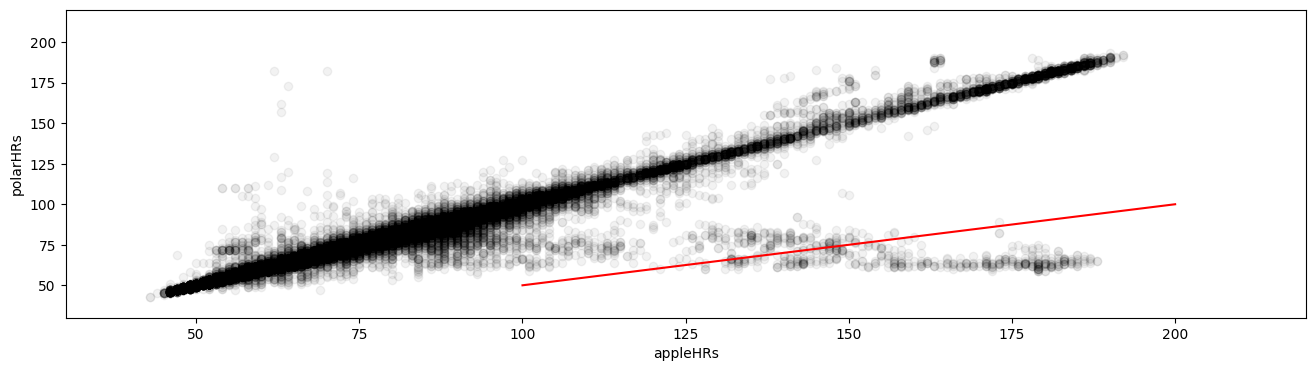

In [25]:
import matplotlib.pyplot as plt

apple_polar_comparisonDF = prepForHRHR(all_intersections, appleHRDf, polarHRDf)
fig, ax = plt.subplots(figsize=(16.0, 4.0))

ax.scatter(x=apple_polar_comparisonDF['value_1'].values, y=apple_polar_comparisonDF['value_2'].values, color='k', alpha=.05)
ax.set_xlabel('appleHRs')
ax.set_ylabel('polarHRs')
ax.set_xlim([30,220])
ax.set_ylim([30,220])
ax.plot([100,200],[50,100], color='r')
plt.show()

In [10]:
appleHRs = getHRsForTimePeriods(all_intersections, appleHRDf)
polarHRs = getHRsForTimePeriods(all_intersections, polarHRDf)

intersectingHRs = appleHRs.join(polarHRs, how='inner', lsuffix="_a", rsuffix="_p")
intersectingHRs['ratio'] = intersectingHRs['value_a'] / intersectingHRs['value_p']
intersectingHRs.head()

,value_a,value_p,ratio
sampleDT,,,
2024-03-09 21:15:55-07:00,106.0,73,1.452055
2024-03-09 21:16:00-07:00,105.0,73,1.438356
2024-03-09 21:16:01-07:00,105.0,73,1.438356
2024-03-09 21:16:06-07:00,105.0,73,1.438356
2024-03-09 21:16:11-07:00,105.0,72,1.458333


In [11]:
intersectingHRs['ratio'].describe()

count    103141.000000
mean          1.009224
std           0.109880
min           0.340659
25%           1.000000
50%           1.000000
75%           1.000000
max           3.050847
Name: ratio, dtype: float64

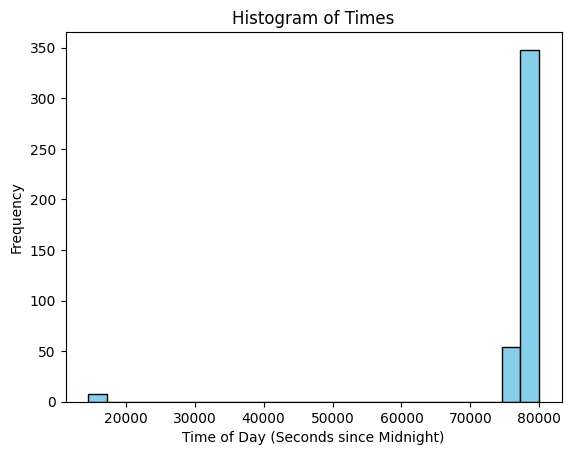

In [29]:
import numpy as np
times = intersectingHRs[intersectingHRs['ratio'] > 2].index.time
time_in_seconds = np.array([t.hour * 3600 + t.minute * 60 + t.second for t in times])
# Plot the histogram
plt.hist(time_in_seconds, bins=24, color='skyblue', edgecolor='black')

# Format the plot
plt.title('Histogram of Times')
plt.xlabel('Time of Day (Seconds since Midnight)')
plt.ylabel('Frequency')

# Show the plot
plt.show()